In [51]:
import numpy as np
import pandas as pd
import requests
from typing import Any
from bs4 import BeautifulSoup
import functools 
import re

pd.set_option('display.max_rows', 2000)

In [ ]:
# https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information?resource=download

In [79]:
df = pd.read_csv('./poets.csv') 

In [ ]:
def get_english_language_poets(file_name: str = "./../data/List of English-language poets - Wikipedia.html"):   
    """
    Function for extraction of english poets names from Wikipedia
    Args:
    file_name - HTML file with poets page
    Returns:
    names_list - list of names
    """
    with open(file_name) as fp:
        soup = BeautifulSoup(fp, "html.parser")
        
    all_containers = soup.find_all("div", class_="div-col")
    name_elements = []
    for c in all_containers:
        name_elements += c.findAll('li')
    names_list = map(lambda n: n.get_text(), name_elements)
    names_list = set(map(lambda n: re.sub("[\(\[].*?[\)\]]", "", n)[:-1], names_list))
    
    return names_list         

In [ ]:
poets = get_english_language_poets()
df = df[df['artist'].isin(poets)]

In [80]:
df['lyrics_paragraphs_count'] = df['lyrics'].apply(lambda l: len(l.split('\n\n')))
df['len_words'] = df['lyrics'].apply(lambda l: len(l.split(' ')))

In [119]:
artists_to_filter = [
    'Kendrick Lamar',
    'Bob Dylan',
    'Christopher Nolan',
    'Henry Fielding',
    'Nick Cave',
    'Charlotte Lennox',
    'Ryan Adams'
]

df = df[(~df['artist'].isin(artists_to_filter))
        & (~df['lyrics'].str.contains("Verse|Hook|Intro"))
        & (df['language'] == "en")
        & (~df['title'].str.contains("Act |ACT |Chapter |Chap. |CHAPTER |Ch. |CHAP."))
       ]

<Axes: >

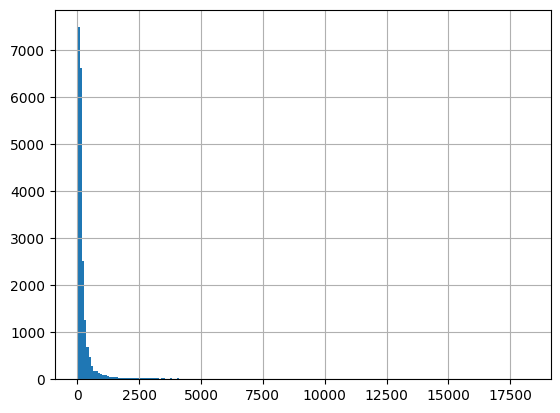

In [113]:
df['len_words'].hist(bins=200)

In [124]:
len(df[df['len_words'] <= 650])

19187

### Get Annotataions

In [90]:
#816515
r = requests.get('https://api.genius.com/referents?song_id=1875&access_token={access_token}')

In [111]:
import json
with open('referents_response.json', 'w') as f:
    json.dump(r.json(), f)

In [12]:
import json
with open('referents_response.json', 'r') as openfile:
    # Reading from json file
    json_object = json.load(openfile)

In [13]:
json_object

{'meta': {'status': 200},
 'response': {'referents': [{'_type': 'referent',
    'annotator_id': 17428,
    'annotator_login': 'SyntheticChild',
    'api_path': '/referents/1304908',
    'classification': 'accepted',
    'fragment': 'The darkest evening of the year.',
    'id': 1304908,
    'is_description': False,
    'path': '/1304908/Robert-frost-stopping-by-woods-on-a-snowy-evening/The-darkest-evening-of-the-year',
    'range': {'content': 'The darkest evening of the year.'},
    'song_id': 1875,
    'url': 'https://genius.com/1304908/Robert-frost-stopping-by-woods-on-a-snowy-evening/The-darkest-evening-of-the-year',
    'verified_annotator_ids': [],
    'annotatable': {'api_path': '/songs/1875',
     'client_timestamps': {'updated_by_human_at': 1603598405,
      'lyrics_updated_at': 1545074249},
     'context': 'Robert Frost',
     'id': 1875,
     'image_url': 'https://images.genius.com/408b4d966deb225996d29dc48625abce.646x1000x1.jpg',
     'link_title': 'Stopping by Woods on a Sn

In [14]:
def traverse_annotation_children(el: Any, annotations: list):
    if type(el) == dict:
        return traverse_annotation_children(el['children'], annotations)
    for c in el:
        if (type(c) == list and len(c) == 1) or type(c) == str:
            annotations.append(c)
        else:
            if 'children' in c:
                traverse_annotation_children(c['children'], annotations)

In [15]:
referents = json_object['response']['referents']
def get_structured_annotation(referents_object: list):
    """
    Flattens the annotations data structure into the list of annotations
    """
    outputs = []
    for ref in referents:
        output = {
            'fragment': ref['fragment'],
            'classification': ref['classification'],
            'annotations': []
        }
        annotations = ref['annotations']
        for a in annotations:
            annotation_object = {
                'verified': a['verified']
            }
            children = a['body']['dom']['children']
            annotated_children = []
            traverse_annotation_children(children, annotated_children)
            annotated_children = list(map(lambda t: t if len(t) > 0 else '\n', annotated_children))
            annotated_children = list(filter(lambda t: 'http' not in t, annotated_children))
            if len(annotated_children[-1]) == 0:
                annotated_children = annotated_children[:len(annotated_children)-2]
            annotated_children = ' '.join(annotated_children)
            annotation_object['text'] = annotated_children
            output['annotations'].append(annotation_object)
        outputs.append(output)
    return outputs

In [28]:
def merge_lyrics_with_annotation_by_paragraph(annotation_object: dict, lyrics: str):
    """
    Function that adds context to each referent with annotion.
    Creates context based on paragraph, not the lines.
    1. Splits into paragraphs '\n\n'
    2. Finds the paragraph of the referent.
    3. Does the same logic as "merge_lyrics_with_annotation" but only within the paragraph.
    """
    LINES_BEFORE = 8
    LINES_AFTER = 8
    
    paragraphs = list(filter(lambda l: len(l) > 0, lyrics.replace("’", "'").split('\n\n')))
    avg_lines_in_paragraph = np.mean([len(p.split('\n')) for p in paragraphs])
    paragraphs_lines = dict(zip(paragraphs, [p.replace("’", "'").split('\n') for p in paragraphs]))
    #poem_lines = list(filter(lambda l: len(l) > 0, lyrics.replace("’", "'").split('\n')))
    for fragment in annotation_object:
        referent = fragment['fragment'].replace("’", "'")
        if '\n' in referent:
            if referent[-1] == '\n':
                referent = referent[:-1]
            referent_list = referent.split('\n')
            referent_start, referent_end = referent_list[0], referent_list[-1]
        else:
            referent_start, referent_end = referent, referent
        
        paragraph_start = list(filter(lambda p: referent_start in p, paragraphs))[0]
        paragraph_end = list(filter(lambda p: referent_end in p, paragraphs))[0]
        
        index_start = paragraphs_lines[paragraph_start].index(referent_start)
        index_end = paragraphs_lines[paragraph_end].index(referent_end)
                
        context_before = paragraphs_lines[paragraph_start][max(index_start-LINES_BEFORE, 0):index_start]
        context_after = paragraphs_lines[paragraph_end][index_end+1:min(index_end+LINES_AFTER, len(paragraphs_lines[paragraph_end]))]
        print(context_before)
        print(referent)
        print(context_after)
        print('\n\n')

In [29]:
def merge_lyrics_with_annotation(annotation_object: dict, lyrics: str):
    """
    Function that adds context to each referent with annotion.
    """
    LINES_BEFORE = 8
    LINES_AFTER = 8
    
    poem_lines = list(filter(lambda l: len(l) > 0, lyrics.replace("’", "'").split('\n')))
    for fragment in annotation_object:
        referent = fragment['fragment'].replace("’", "'")
        if '\n' in referent:
            if referent[-1] == '\n':
                referent = referent[:-1]
            referent_list = referent.split('\n')
            referent_start, referent_end = referent_list[0], referent_list[-1]
        else:
            referent_start, referent_end = referent, referent
        
        
        index_start = poem_lines.index(referent_start)
        index_end = poem_lines.index(referent_end)
                
        context_before = poem_lines[max(index_start-LINES_BEFORE, 0):index_start]
        context_after = poem_lines[index_end+1:min(index_end+LINES_AFTER, len(poem_lines))]
        print(context_before)
        print(referent)
        print(context_after)
        print('\n\n')

In [30]:
merge_lyrics_with_annotation(get_structured_annotation(referents), df[df['id'] == 1875]['lyrics'].values[0])

['Whose woods these are I think I know.', 'His house is in the village though;', 'He will not see me stopping here', 'To watch his woods fill up with snow.', 'My little horse must think it queer', 'To stop without a farmhouse near', 'Between the woods and frozen lake']
The darkest evening of the year.
['He gives his harness bells a shake', 'To ask if there is some mistake.', "The only other sound's the sweep", 'Of easy wind and downy flake.', 'The woods are lovely, dark and deep,', 'But I have promises to keep,', 'And miles to go before I sleep,']



['Between the woods and frozen lake', 'The darkest evening of the year.', 'He gives his harness bells a shake', 'To ask if there is some mistake.', "The only other sound's the sweep", 'Of easy wind and downy flake.', 'The woods are lovely, dark and deep,', 'But I have promises to keep,']
And miles to go before I sleep,
And miles to go before I sleep.
[]



['To stop without a farmhouse near', 'Between the woods and frozen lake', 'The darke

In [141]:
get_structured_annotation(referents)

[{'fragment': 'The darkest evening of the year.',
  'classification': 'accepted',
  'annotations': [{'verified': False,
    'text': 'On the surface this refers to the  winter solstice  here, but upon closer examination it may have, well, darker connotations. \n The “darkest evening of the year” could suggest the speaker’s own psychological state. Perhaps he has something negative weighing on him, taking his mind to darker places than it’s gone before. Some critics have even read this as a reference to suicidal despair–a reading that  Frost publicly resisted: \n \n Indeed, critics sometimes set his teeth on edge with intimations about personal themes in the poem, as if it expressed a wish quite literally for suicide or marked some especially dark passage in the poet’s life. Louis Mertins quotes him in conversation (and similar remarks may be found in transcripts of a number of Frost’s public readings): \n “I suppose people think I lie awake nights worrying about what people like [John] 